# Fine-tuning performance of multilingual models 

In [ ]:
import torch, os
from google.colab import drive
drive.mount('/content/drive')
if os.getcwd() != "/content/drive/My Drive/akademi/Packt NLP with Transformers/CH09":
  os.chdir("drive/MyDrive/akademi/Packt NLP with Transformers/CH09")

Mounted at /content/drive


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 6.6MB/s 


In [ ]:
!pip install transformers datasets

     |████████████████████████████████| 2.3MB 6.3MB/s 
     |████████████████████████████████| 235kB 21.9MB/s 
     |████████████████████████████████| 901kB 21.7MB/s 
     |████████████████████████████████| 3.3MB 36.6MB/s 
     |████████████████████████████████| 245kB 25.0MB/s 
     |████████████████████████████████| 112kB 36.3MB/s 


## Loading Pre-Trained Model

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

### Obtaining and Preparing downstream task data

In [ ]:
if "TTC4900.csv" not in os.listdir():
 !wget  https://raw.githubusercontent.com/savasy/TurkishTextClassification/master/TTC4900.csv
else:
   print("Already there !")

Already there !


In [ ]:
import pandas as pd
data= pd.read_csv("TTC4900.csv")
data=data.sample(frac=1.0, random_state=42)
data.head(5)

,category,text
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...
3539,spor,g saray a git santos van_persie den forma ala...
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...


In [ ]:
labels=["teknoloji","ekonomi","saglik","siyaset","kultur","spor","dunya"]
NUM_LABELS= len(labels)
id2label={i:l for i,l in enumerate(labels)}
label2id={l:i for i,l in enumerate(labels)}

In [ ]:
label2id

{'dunya': 6,
 'ekonomi': 1,
 'kultur': 4,
 'saglik': 2,
 'siyaset': 3,
 'spor': 5,
 'teknoloji': 0}

In [ ]:
data["labels"]=data.category.map(lambda x: label2id[x.strip()])

In [ ]:
data.head()

,category,text,labels
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...,0
3539,spor,g saray a git santos van_persie den forma ala...,5
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...,6
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...,0
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...,5


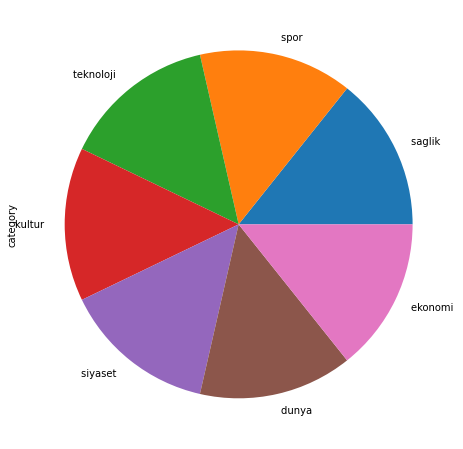

In [ ]:
data.category.value_counts().plot(kind='pie', figsize=(8,8))

## BERT

In [ ]:
#from transformers import BertTokenizerFast
#tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length=512)
#from transformers import BertForSequenceClassification
#model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)

# We will run the fine-tuning computations from the previous chapter again with new pre-traine model

We either instatiate mBERT or XLM-R. Firts we go with mBERT, then we will use XLM-R. Currently we instantiate mBERT and we comment out XLM-R code block as follows:


# mBERT

In [ ]:
from transformers import BertForSequenceClassification, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

## XLM-R

Official Note of XLM-R:
This model was pre-trained on set of 100 languages, as described in the original paper.
It was then fine-tuned on the task of NLI on the concatenated MNLI train set and the XNLI validation and test sets. Finally, it was trained for one additional epoch on only XNLI data where the translations for the premise and hypothesis are shuffled such that the premise and hypothesis for each example come from the same original English example but the premise and hypothesis are of different languages.

In [1]:
'''
from transformers import AutoTokenizer, XLMRobertaForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

SyntaxError: ignored

In [ ]:
!nvidia-smi

Tue Jun  1 08:07:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    36W / 250W |   2011MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Splitting data


In [ ]:
SIZE= data.shape[0]

train_texts= list(data.text[:SIZE//2])
val_texts=   list(data.text[SIZE//2:(3*SIZE)//4 ])
test_texts=  list(data.text[(3*SIZE)//4:])

train_labels= list(data.labels[:SIZE//2])
val_labels=   list(data.labels[SIZE//2:(3*SIZE)//4])
test_labels=  list(data.labels[(3*SIZE)//4:])

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

(2450, 1225, 1225)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = MyDataset(train_encodings, train_labels)
val_dataset = MyDataset(val_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

## Training with Trainer Class

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support 
def compute_metrics(pred): 
    labels = pred.label_ids 
    preds = pred.predictions.argmax(-1) 
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro') 
    acc = accuracy_score(labels, preds) 
    return { 
        'Accuracy': acc, 
        'F1': f1, 
        'Precision': precision, 
        'Recall': recall 
    } 

In [ ]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="epoch", 
    fp16=True,
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.909000,1.640363,0.462857,0.385107,0.400540,0.458520
100,1.050700,0.606919,0.800816,0.785080,0.839718,0.803712
150,0.579700,0.815248,0.725714,0.706009,0.854710,0.724133
200,0.469800,0.496873,0.852245,0.850184,0.870633,0.852877
250,0.355200,0.346857,0.900408,0.899246,0.903131,0.899766
300,0.335900,0.347584,0.905306,0.905045,0.911391,0.905030
350,0.208000,0.387149,0.905306,0.905070,0.907696,0.905757
400,0.216500,0.339011,0.912653,0.912454,0.913331,0.912042
450,0.179900,0.341186,0.920000,0.919543,0.920086,0.920174


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=462, training_loss=0.5774300795096856, metrics={'train_runtime': 1304.5819, 'train_samples_per_second': 0.354, 'total_flos': 0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 118784, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -180760576, 'train_mem_gpu_alloc_delta': 3356533248, 'train_mem_cpu_peaked_delta': 200425472, 'train_mem_gpu_peaked_delta': 10878653952})

In [ ]:
q=[trainer.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]
pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.122369,0.968571,0.968665,0.968830,0.968862
val,0.339011,0.912653,0.912454,0.913331,0.912042
test,0.334882,0.915918,0.915662,0.918334,0.914893
